In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.metrics.pairwise import linear_kernel

import pandas as pd
import numpy as np
import seaborn as sns 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
df = pd.read_csv('/Users/elmi/Projects/CloudWine/data/raw/winemag-data-130k-v2.csv')
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
df = df[(df['variety'].notna()) & (df['region_1'].notna())]
df['variety_region'] = df[['variety', 'region_1']].agg('-'.join, axis=1)

In [4]:
top_prov = df['variety_region'].value_counts().nlargest(10).index.tolist()
data_subset = df[df['variety_region'].isin(top_prov)]
data_subset = data_subset.reset_index(drop=True)

In [5]:
train_set = data_subset[['description','title']]
corpus = train_set['description'].tolist()

In [6]:
def plot_tsne(x,y):
    feat_cols = [ 'embedding'+str(i) for i in range(x.shape[1]) ]
    df_embed = pd.DataFrame(x,columns=feat_cols)
    df_embed['y'] = y
    
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(x)
    
    df_embed['size'] = 0
    df_embed.loc[df_embed['y'] != 'unknown','size'] = 10
    
    df_embed['tsne-2d-one'] = tsne_results[:,0]
    df_embed['tsne-2d-two'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        size="size",
    #     palette=sns.color_palette("hls"),
        data=df_embed,
        legend="full",
        alpha=0.8
    )

In [37]:
def plot_pca(x,y):
    feat_cols = [ 'embedding'+str(i) for i in range(x.shape[1]) ]
    df_embed = pd.DataFrame(x,columns=feat_cols)
    df_embed['y'] = y
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(x)
    df_embed['pca-one'] = pca_result[:,0]
    df_embed['pca-two'] = pca_result[:,1]
    
    df_embed['size'] = 0
    df_embed.loc[df_embed['y'] != 'unknown','size'] = 10
    
    
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="pca-one", y="pca-two",
        hue="y",
#         size="size",
    #     palette=sns.color_palette("hls"),
        data=df_embed,
        legend="full",
        alpha=0.8
    )

## TF-IDF Model

In [8]:
len(corpus)

11864

In [9]:
data_subset.shape

(11864, 15)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=1, stop_words="english")
X = vectorizer.fit_transform(corpus)

In [39]:
x = X.toarray()
y = data_subset['variety_region'].to_numpy()

# plot_tsne(x,y)

In [40]:
x.shape

(11864, 10267)

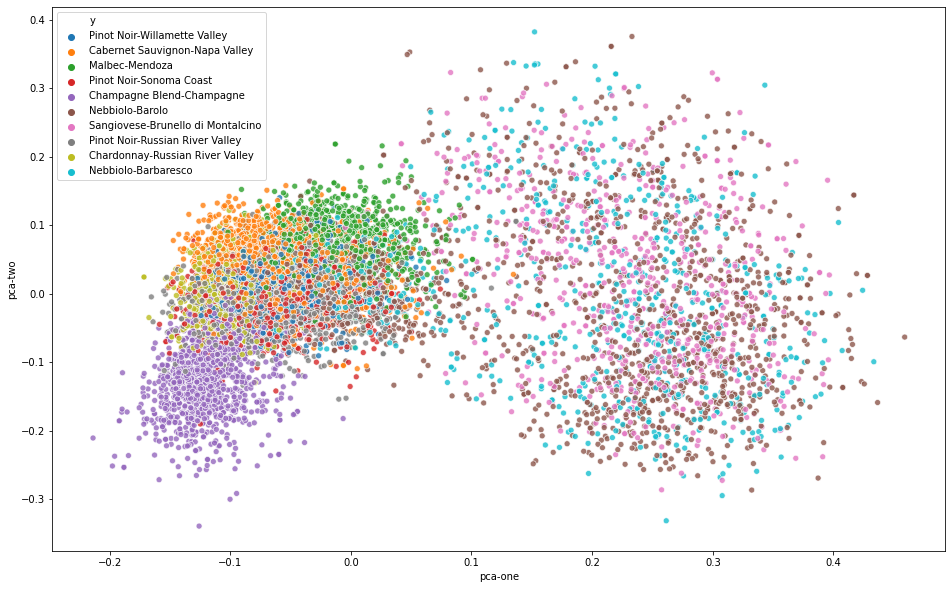

In [41]:
plot_pca(x,y)

In [14]:
y

array(['Pinot Noir-Willamette Valley', 'Cabernet Sauvignon-Napa Valley',
       'Malbec-Mendoza', ..., 'Pinot Noir-Sonoma Coast', 'Malbec-Mendoza',
       'Malbec-Mendoza'], dtype=object)

In [15]:
labels = data_subset['variety_region'].unique()
for l in labels:
    idx = data_subset[data_subset['variety_region'] == l].index.to_numpy()
    x_cluster = x[idx]
    cluster_mean = np.mean(x_cluster, axis=0)
    out = np.mean(cosine_similarity([cluster_mean], x_cluster).flatten())
    print(l, out)
    

Pinot Noir-Willamette Valley 0.17382654143060058
Cabernet Sauvignon-Napa Valley 0.20750666894758255
Malbec-Mendoza 0.24604386041712736
Pinot Noir-Sonoma Coast 0.18810872341163126
Champagne Blend-Champagne 0.2679544391946899
Nebbiolo-Barolo 0.29020693591751867
Sangiovese-Brunello di Montalcino 0.3402222675457065
Pinot Noir-Russian River Valley 0.18769287417013605
Chardonnay-Russian River Valley 0.21475990056703248
Nebbiolo-Barbaresco 0.2915547940904757


In [16]:
l = 'Pinot Noir-Willamette Valley'
idx = data_subset[data_subset['variety_region'] == l].index.to_numpy()


In [17]:
data_subset[data_subset['variety_region'] == l]

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,variety_region
0,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Pinot Noir-Willamette Valley
4,41,US,"A stiff, tannic wine, this slowly opens and br...",NaN,86,22.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Hawkins Cellars 2009 Pinot Noir (Willamette Va...,Pinot Noir,Hawkins Cellars,Pinot Noir-Willamette Valley
18,173,US,This wine is bursting with gorgeous cherry fru...,NaN,91,38.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Le Cadeau 2014 Pinot Noir (Willamette Valley),Pinot Noir,Le Cadeau,Pinot Noir-Willamette Valley
24,233,US,"There is an odd, piercing edge to the aromas, ...",Reserve,85,28.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Silvan Ridge 2006 Reserve Pinot Noir (Willamet...,Pinot Noir,Silvan Ridge,Pinot Noir-Willamette Valley
26,248,US,This seems as if it was assembled from lesser ...,Estate Single Vineyard,85,45.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Amity 2006 Estate Single Vineyard Pinot Noir (...,Pinot Noir,Amity,Pinot Noir-Willamette Valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11808,129542,US,Elizabeth's Reserve is comprised of Adelsheim'...,Elizabeth's Reserve,89,55.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Adelsheim 2011 Elizabeth's Reserve Pinot Noir ...,Pinot Noir,Adelsheim,Pinot Noir-Willamette Valley
11831,129663,US,Sourced from one of the finest vineyards in Or...,Shea Vineyard,93,60.0,Oregon,Willamette Valley,NaN,Paul Gregutt,@paulgwine,Winderlea 2014 Shea Vineyard Pinot Noir,Pinot Noir,Winderlea,Pinot Noir-Willamette Valley
11841,129736,US,This has the pretty slightly candied flavors o...,NaN,90,22.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Black Magnolia 2015 Pinot Noir (Willamette Val...,Pinot Noir,Black Magnolia,Pinot Noir-Willamette Valley
11844,129745,US,"Good grip is immediately apparent, along with ...",NaN,90,28.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Clay Pigeon 2013 Pinot Noir (Willamette Valley),Pinot Noir,Clay Pigeon,Pinot Noir-Willamette Valley


In [18]:
x_cluster = x[idx]
cluster_mean = np.mean(x_cluster, axis=0)
out = np.mean(cosine_similarity([cluster_mean], x_cluster).flatten())
print(l, out)

Pinot Noir-Willamette Valley 0.17382654143060058


## Doc2Vec

In [19]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [20]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(corpus)]

In [42]:
max_epochs = 150
vec_size = 100
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha


/opt/anaconda3/envs/cloudwine/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


<ipython-input-42-17037a545dda>:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  epochs=model.iter)


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [43]:
docvecs = model.docvecs['0']
for i in range(1,len(corpus)):
    docvecs = np.vstack((docvecs, model.docvecs[str(i)]))
docvecs

array([[ 0.8930233 ,  3.5346882 , -0.9448794 , ..., -0.5146878 ,
         0.12500092,  1.7373728 ],
       [ 0.22102006,  2.0408974 ,  0.16317476, ...,  3.8357842 ,
         1.7837018 , -1.1250743 ],
       [ 0.09172404, -1.922802  ,  1.902281  , ...,  0.21285108,
         3.8105    , -4.024261  ],
       ...,
       [-0.87175095, -0.36384252,  3.7176273 , ...,  0.35415986,
        -1.0431668 ,  1.270424  ],
       [ 0.18869926,  1.2907716 , -0.64659894, ..., -3.3018396 ,
         0.23368384, -0.28655916],
       [-2.4071898 , -3.3898058 ,  2.1762428 , ...,  2.2059653 ,
         0.7643419 , -0.9483875 ]], dtype=float32)

In [44]:
docvecs.shape

(11864, 100)

In [45]:
labels = data_subset['variety_region'].unique()
for l in labels:
    idx = data_subset[data_subset['variety_region'] == l].index.to_numpy()
    x_cluster = docvecs[idx]
    cluster_mean = np.mean(x_cluster, axis=0)
    out = np.mean(cosine_similarity([cluster_mean], x_cluster).flatten())
    print(l, out)
    

Pinot Noir-Willamette Valley 0.45999622
Cabernet Sauvignon-Napa Valley 0.43954167
Malbec-Mendoza 0.48965815
Pinot Noir-Sonoma Coast 0.4295225
Champagne Blend-Champagne 0.4929076
Nebbiolo-Barolo 0.48570028
Sangiovese-Brunello di Montalcino 0.5135539
Pinot Noir-Russian River Valley 0.42697275
Chardonnay-Russian River Valley 0.48553333
Nebbiolo-Barbaresco 0.4840417


In [46]:
x = docvecs
y = data_subset['variety_region'].to_numpy()


In [47]:
# plot_tsne(x,y)

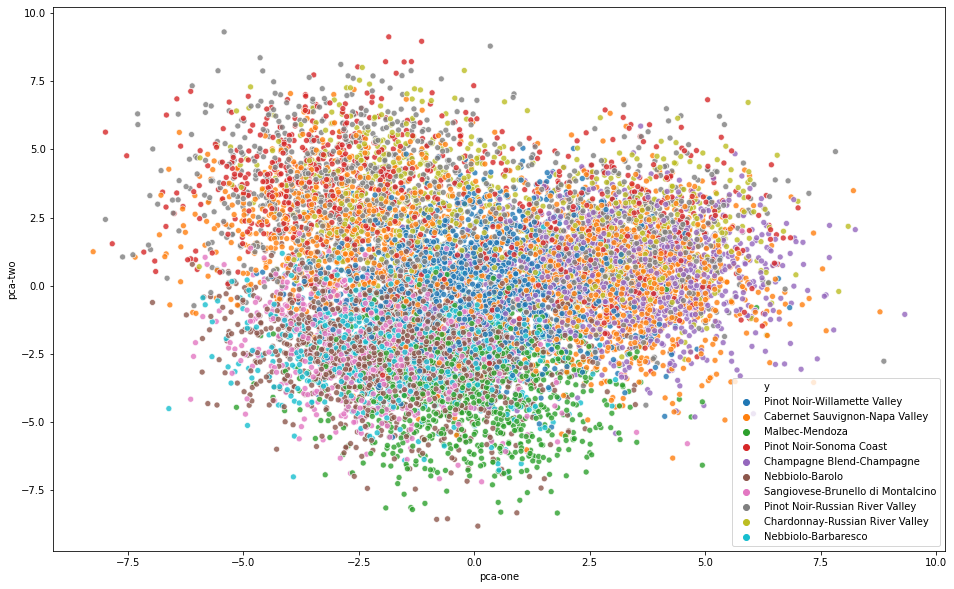

In [48]:
plot_pca(x,y)

In [26]:
data_subset.shape

(11864, 15)

In [27]:
data_subset

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,variety_region
0,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Pinot Noir-Willamette Valley
1,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,Cabernet Sauvignon-Napa Valley
2,17,Argentina,Raw black-cherry aromas are direct and simple ...,Winemaker Selection,87,13.0,Mendoza Province,Mendoza,NaN,Michael Schachner,@wineschach,Gaucho Andino 2011 Winemaker Selection Malbec ...,Malbec,Gaucho Andino,Malbec-Mendoza
3,25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa,Pinot Noir-Sonoma Coast
4,41,US,"A stiff, tannic wine, this slowly opens and br...",NaN,86,22.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Hawkins Cellars 2009 Pinot Noir (Willamette Va...,Pinot Noir,Hawkins Cellars,Pinot Noir-Willamette Valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11859,129892,Italy,"Classic Sangiovese aromas of red berry, culina...",NaN,91,72.0,Tuscany,Brunello di Montalcino,NaN,Kerin O’Keefe,@kerinokeefe,La Mannella 2012 Brunello di Montalcino,Sangiovese,La Mannella,Sangiovese-Brunello di Montalcino
11860,129906,US,Pencil shaving and graphite notes lend a class...,NaN,91,35.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Conn Creek 2013 Cabernet Sauvignon (Napa Valley),Cabernet Sauvignon,Conn Creek,Cabernet Sauvignon-Napa Valley
11861,129912,US,From the Ranch House block of the famous viney...,Durell Vineyard,91,55.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Dunstan 2014 Durell Vineyard Pinot Noir (Sonom...,Pinot Noir,Dunstan,Pinot Noir-Sonoma Coast
11862,129917,Argentina,"This dark, meaty Malbec has some Agrelo fruit ...",Piedra Negra,91,40.0,Mendoza Province,Mendoza,NaN,Michael Schachner,@wineschach,J. & F. Lurton 2004 Piedra Negra Malbec (Mendoza),Malbec,J. & F. Lurton,Malbec-Mendoza
